# 1. Import libraries and data 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from pickle import dump, load


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict
RSEED=42

In [2]:
# import functions from the project

#get_path = os.path.abspath("")
project_path = 'd:\\PYTHON\\CS_Bootcamp\\programs\\cs-intrusion-detection-system'

# add path to load own functions from .py files in scrips folder
sys.path.insert(0, project_path + '\scripts')

from preprocessing import *
from plotting import *
from model_evaluation import *



In [3]:
# get data 
file_name_train_data = "KDDTrain+.txt"
file_name_test_tata = "KDDTest+.txt"

# column names
column_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "attack_type",
    "difficulty_level"
]

# load data as df
train_data = pd.read_csv("../data/"+ file_name_train_data,  names=column_names)
test_data = pd.read_csv("../data/"+ file_name_test_tata, names=column_names)

print(train_data.shape)
print(test_data.shape)

(125973, 43)
(22544, 43)


# 2. Preprocessing / feature engineering
1. Recode categorical features to category
2. Recode numerical features to binary category (based on EDA)
3. Recode numerical features to three categories (based on EDA)
4. Create binary target variable (attack: 0,1)

- Other numerical features are not further processed (**NUM_FEATURES**)
- all processed categorical features are added to **CAT_FEATURES**


In [4]:
# features to process 
NUM_FEATURES = set([
    'srv_serror_rate',
    'same_srv_rate',
    'dst_host_same_srv_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_count',
    'duration',
    'src_bytes',
    'dst_host_diff_srv_rate',
    'dst_host_srv_serror_rate',
    'dst_host_serror_rate',
    'srv_count',
    'dst_host_srv_rerror_rate',
    'dst_bytes',
    'dst_host_srv_count',
    'serror_rate',
    'diff_srv_rate',
    'dst_host_same_src_port_rate',
    'srv_diff_host_rate',
    'srv_rerror_rate',
    'dst_host_rerror_rate',
    'rerror_rate',
    'count'])

CAT_FEATURES = set(['logged_in', 'root_shell', 'is_guest_login', 'land', 'flag', 'difficulty_level', 'protocol_type', 'service'])

# features for recoding numerical to categorical
to_recode_2_cat = ['num_shells',
                    'urgent',
                    'num_root',           # --> works with threshold .99
                    'num_file_creations',
                    'num_failed_logins',
                    'su_attempted',
                    'num_access_files',
                    'wrong_fragment',     # --> works with threshold .99
                    ]

# unfortunatelly hardcoded boundaries for now: 
to_recode_3_cat = {'num_compromised': 10, 
                       'hot': 5} 
condition_labels = ["none", "low", "high"] 


# recode to binary target variable (attack vs no attack)
target_feature = "attack_type" 

In [5]:
# 1. convert categorical features to categories 
for feature in list(CAT_FEATURES):
    train_data = convert_column_type(train_data, feature, 'category' )
    test_data = convert_column_type(test_data, feature, 'category' )


In [6]:
# 2. recode numerical to binary categorical features 
for feature in to_recode_2_cat:
    new_feature_name = feature + "_cat"
    recode_to_binary_feature(train_data, feature, new_feature_name)
    recode_to_binary_feature(test_data, feature, new_feature_name, threshold=0) # don't use the threshold here

    # add recoded features to CAT_FEATURES 
    if is_categorical_dtype(train_data, new_feature_name) & is_categorical_dtype(
        test_data, new_feature_name):
        # add only when both successfully transformed 
        CAT_FEATURES.add(new_feature_name)
    else:
        print(f"Feature {new_feature_name} not added, check processing.")

In [7]:
# 3. recode numerical features to 3 category features

for feature, bound in to_recode_3_cat.items(): 
    cond_train = get_conditions(train_data, feature, bound)
    cond_test = get_conditions(test_data, feature, bound)
    new_feature_name = feature +"_cat"

    recode_to_categories(train_data, new_feature_name, cond_train, condition_labels)
    recode_to_categories(test_data, new_feature_name, cond_test, condition_labels)

    # add recoded features to CAT_FEATURES 
    if is_categorical_dtype(train_data, new_feature_name) & is_categorical_dtype(
        test_data, new_feature_name):
        # add only when both successfully transformed 
        CAT_FEATURES.add(new_feature_name)
    else:
        print(f"Feature {new_feature_name} not added, check processing.")


In [8]:
# 4. recode target feature 

recode_binary_target_feature(train_data, target_feature, "attack")
recode_binary_target_feature(test_data, target_feature, "attack")

if is_categorical_dtype(train_data, "attack") & is_categorical_dtype(
        test_data, "attack"):
    print("New target variable created succsessfully.")
else:
    print("Something went wrong with the target variable!")



New target variable created succsessfully.


In [9]:
# we have now done the preprocessing for all features
numerical_features = list(NUM_FEATURES)
categorical_features = list(CAT_FEATURES)

print(f"There are {len(numerical_features)} numerical and {len(categorical_features)} categorical features.")

There are 22 numerical and 18 categorical features.


In [10]:
numerical_features

['dst_host_diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'duration',
 'srv_diff_host_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'srv_serror_rate',
 'diff_srv_rate',
 'count',
 'dst_host_count',
 'src_bytes',
 'serror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_count',
 'dst_host_srv_diff_host_rate',
 'dst_bytes',
 'same_srv_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_serror_rate',
 'dst_host_same_srv_rate',
 'srv_count']

In [11]:
categorical_features

['urgent_cat',
 'land',
 'service',
 'flag',
 'num_file_creations_cat',
 'num_access_files_cat',
 'protocol_type',
 'root_shell',
 'num_failed_logins_cat',
 'num_compromised_cat',
 'wrong_fragment_cat',
 'hot_cat',
 'su_attempted_cat',
 'num_root_cat',
 'num_shells_cat',
 'is_guest_login',
 'difficulty_level',
 'logged_in']

In [ ]:
# TODO: further export the preprocessing functionality
# TODO: for feature difficulty reduce nr of categories 

# 3. Train Test split

In [12]:
# define data sets for training tthe model and for testing the model

X_train = train_data[numerical_features + categorical_features]
y_train = train_data["attack"]  # target

X_test = test_data[numerical_features + categorical_features]
y_test = test_data["attack"]    # target

print('X_train dimensions:', X_train.shape)
print('X_test dimensions:', X_test.shape)
print('y_train dimensions:', y_train.shape)
print('y_test dimensions:', y_test.shape)

X_train dimensions: (125973, 40)
X_test dimensions: (22544, 40)
y_train dimensions: (125973,)
y_test dimensions: (22544,)


# 4. Pipelines

In [13]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='constant'))   
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Columntransformer (combines preprocessing pipeline with features)
preprocessor = ColumnTransformer([
    #('num', num_pipeline, numerical_features), # no preprocessing for num features atm 
    ('cat', cat_pipeline, categorical_features)
])

# Random forest model
pipeline_rand_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestClassifier(random_state=RSEED))
])

In [14]:
# test 1hot encoding
Onehot = OneHotEncoder(handle_unknown='ignore')
X_train_ft = Onehot.fit_transform(X_train[categorical_features])    # fitting only on training data
X_test_t = Onehot.transform(X_test[categorical_features])           # transforming on both   

# gete feature names output 
feature_names = Onehot.get_feature_names_out()
#print(feature_names)

In [15]:
# test onehotencoding with preprocessor (ColumnTransformer)
X_fit_trans = preprocessor.fit_transform(X_train)
y_fit = preprocessor.fit(X_test)

# gete feature names output 
feature_names = preprocessor.get_feature_names_out()
#print(feature_names)

# 5. Train random forest model

In [16]:
# basic random forest model 
pipeline_rand_forest.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
# make predictions using random forest model 
y_test_pred = pipeline_rand_forest.predict(X_test)

# ann qucikly look at the scores
print(f"Training data score: {round(pipeline_rand_forest.score(X_train, y_train)*100,2)}")
print(f"Test data score: {round(pipeline_rand_forest.score(X_test, y_test)*100,2)}")

Training data score: 98.58
Test data score: 83.3


# 6. Hyperparameter tuning (Optional)
Using GridSearchCV or randomized GridSearchCV to improve the random forest model 
by fining better hyperparameters

In [ ]:
# perform gridsearch to find best parameters for randomforest model

# Gridsearch CV - define the grid 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
param_grid = {'forest__n_estimators': n_estimators,
              'forest__max_features': max_features,
              'forest__max_depth': max_depth,
              'forest__min_samples_split': min_samples_split,
              'forest__min_samples_leaf': min_samples_leaf,
              'forest__bootstrap': bootstrap
              }

# Hyperparameter grid
param_grid2 = {
    'forest__n_estimators': np.linspace(10, 200).astype(int),
    'forest__max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'forest__max_features': ['sqrt', 'log2', None] + list(np.arange(0.5, 1, 0.1)),
    'forest__max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'forest__min_samples_split': [2, 5, 10],
    'forest__bootstrap': [True],
    'forest__criterion': ['gini', 'entropy', 'log_loss']
}


In [ ]:
# a complete gridserach takes a lot of time - better do a randomized grid search
grid_search = GridSearchCV(pipeline_rand_forest,    # estimator 
                           param_grid=param_grid, 
                           #scoring='accuracy',     # model evaluation metric: 'accuracy', 'recall', 'precision'
                           verbose=1, 
                           n_jobs=-1,               # nr jobs run in parallel (-1 menas all processors)
                           cv=5)                    # cross validation splitting strategy, None defaults to 5

# grid_search.fit(X_train, y_train) # mot finished after 800 m (9900 fits)
#print(grid_search.best_estimator_)

In [ ]:
# do a randomized grid search if time is of the essence
grid_rand_forest = RandomizedSearchCV(pipeline_rand_forest, 
                                      param_grid2, 
                                      cv=5, 
                                      n_iter = 5,
                                      verbose=10,
                                      #scoring='f1_weighted', 
                                      n_jobs=-1)

grid_rand_forest.fit(X_train, y_train) # totalling 25 fits (Fitting 5 folds for each of 5 candidates)

In [ ]:
# RandomizedSearchCV default: refit=True (default)
# an estimator using the best found parameters is refit on the whole dataset
# The refitted estimator is made available at the best_estimator_ attribute and 
# permits using predict directly on this RandomizedSearchCV instance.

# Show best parameters
print('Best score:     {:.2f}'.format(grid_rand_forest.best_score_))
print("Best parameters:{}".format(grid_rand_forest.best_params_))
print(f"Features:\n{grid_rand_forest.feature_names_in_}")
best_model = grid_rand_forest.best_estimator_
best_model

In [ ]:
print(grid_rand_forest.best_estimator_._final_estimator.criterion)
print(grid_rand_forest.best_estimator_._final_estimator.n_features_in_)
print(grid_rand_forest.best_estimator_._final_estimator.estimators_) 

In [ ]:
grid_rand_forest.best_estimator_._final_estimator.feature_importances_

## Save best model

In [ ]:
# save the best model as pfl file
best_model_name='random_forest_model'
dump(best_model, open(f'{best_model_name}.pkl', 'wb'))

# 7. Predictions

In [18]:
# make predictions usinge baseline models 
m1_train_pred = baseline_model_genuine(X_train)
m1_test_pred = baseline_model_genuine(X_test)

m2_train_pred = baseline_model_random(X_train)
m2_test_pred = baseline_model_random(X_test)

m3_train_pred = baseline_model_risky_protocol(X_train)
m3_test_pred = baseline_model_risky_protocol(X_test)


In [ ]:
# load best model, if you have not done the hyperparameter tuning in this run 
best_forest_model = load(open('random_forest_model.pkl', 'rb'))

In [22]:
# make redictions using random forest model pipeline
rf_result1 = make_predictions(pipeline_rand_forest, X_train, X_test)
rf_best_result = make_predictions(best_forest_model, X_train, X_test)

# 8. Evaluation

## Baseline models 

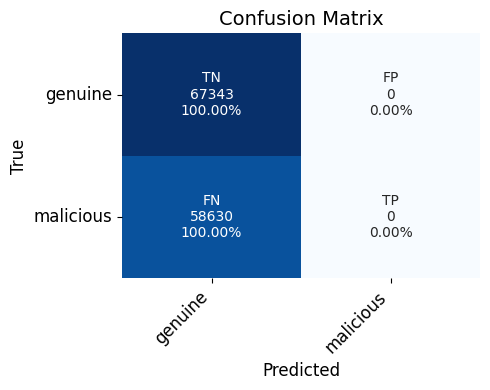

Accuracy  53.46%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 0.0%  --> Correctness: proportion of attack detections that were correct.
Recall    0.0%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [23]:
# B1 train : always predict 0 (normal network traffic)
plot_confusion_matrix(y_train, m1_train_pred, ["genuine", "malicious"], normalize='true', verbose=1)

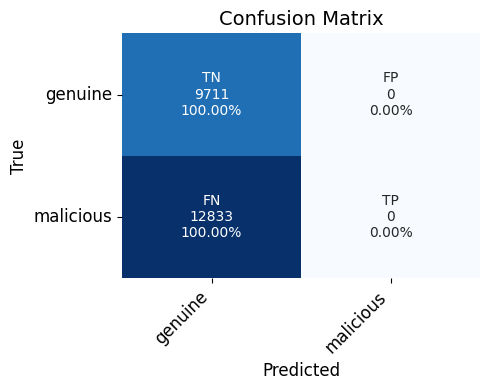

Accuracy  43.08%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 0.0%  --> Correctness: proportion of attack detections that were correct.
Recall    0.0%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [24]:
# B1 test: always predict 0 (normal network traffic)
plot_confusion_matrix(y_test, m1_test_pred, ["genuine", "malicious"], normalize='true', verbose=1)

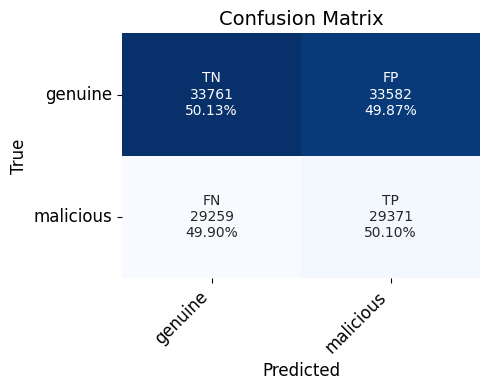

Accuracy  50.12%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 46.66%  --> Correctness: proportion of attack detections that were correct.
Recall    50.1%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [25]:
# B2 train. randomly predict genuine or malicious network traffic 
plot_confusion_matrix(y_train, m2_train_pred, ["genuine", "malicious"], normalize='true', verbose=1)

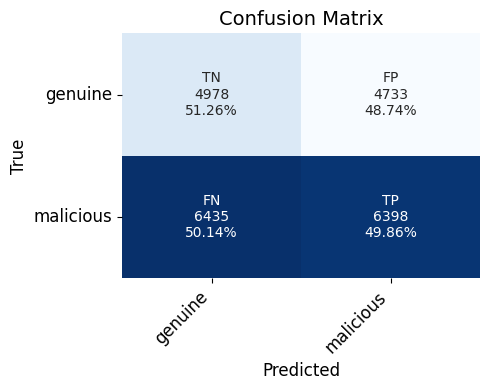

Accuracy  50.46%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 57.48%  --> Correctness: proportion of attack detections that were correct.
Recall    49.86%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [26]:
# B2 test. randomly predict genuine or malicious network traffic 
plot_confusion_matrix(y_test, m2_test_pred, ["genuine", "malicious"], normalize='true', verbose=1)

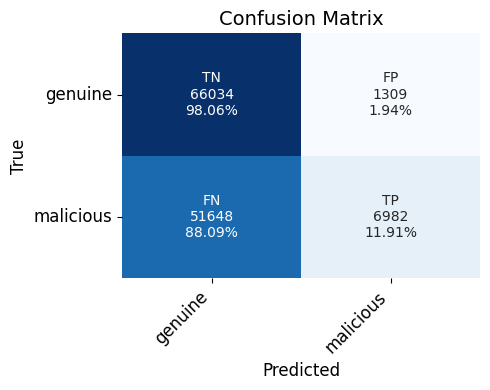

Accuracy  57.96%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 84.21%  --> Correctness: proportion of attack detections that were correct.
Recall    11.91%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [27]:
# B3 train: predict malicous network traffic wenn icmp protcol is used
plot_confusion_matrix(y_train, m3_train_pred, ["genuine", "malicious"], normalize='true', verbose=1)


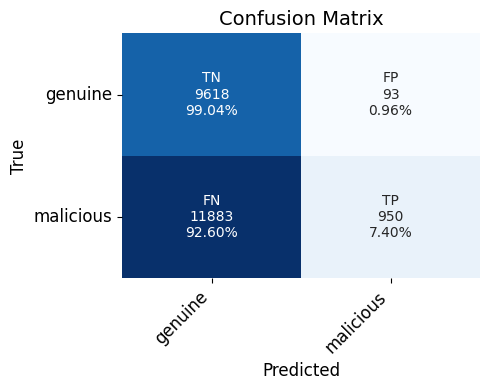

Accuracy  46.88%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 91.08%  --> Correctness: proportion of attack detections that were correct.
Recall    7.4%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [28]:
# B3 test: predict malicous network traffic wenn icmp protcol is used 
plot_confusion_matrix(y_test, m3_test_pred, ["genuine", "malicious"], normalize='true', verbose=1)

## Random forest models

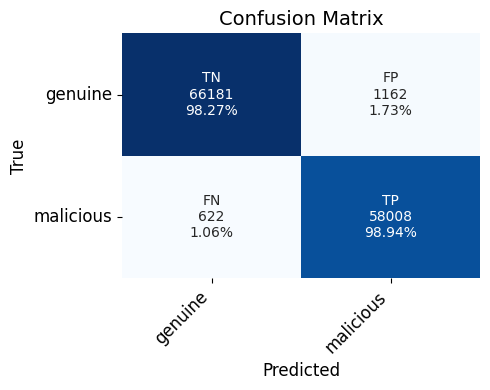

Accuracy  98.58%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 98.04%  --> Correctness: proportion of attack detections that were correct.
Recall    98.94%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [29]:
# RFM train: basic random forest train evaluation 
plot_confusion_matrix(y_train, rf_result1[0], ["genuine", "malicious"], normalize='true', verbose=1)

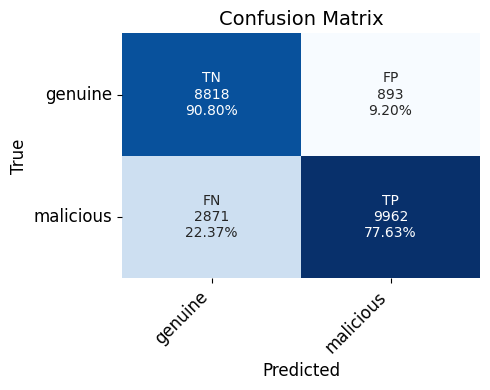

Accuracy  83.3%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 91.77%  --> Correctness: proportion of attack detections that were correct.
Recall    77.63%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [30]:
# RFM test: basic random forest test evaluation 
plot_confusion_matrix(y_test, rf_result1[2], ["genuine", "malicious"], normalize='true', verbose=1)

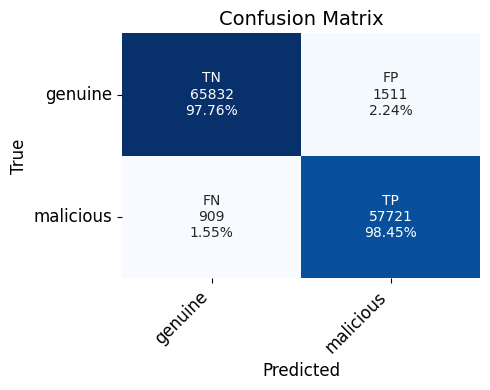

Accuracy  98.08%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 97.45%  --> Correctness: proportion of attack detections that were correct.
Recall    98.45%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [31]:
# RFM train: best random forest train evaluation 
plot_confusion_matrix(y_train, rf_best_result[0], ["genuine", "malicious"], normalize='true', verbose=1)

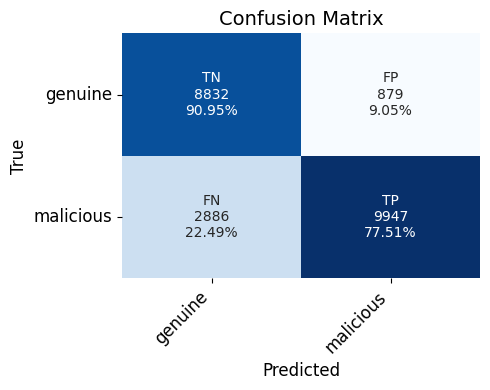

Accuracy  83.3%  --> Proportion of all classifications (TN and TP) that were correct.
Precision 91.88%  --> Correctness: proportion of attack detections that were correct.
Recall    77.51%  --> Sensitivity (TPR): proportion of actual attacks that could be correctly identified.


In [32]:
# RFM best random forest test evaluation 
plot_confusion_matrix(y_test, rf_best_result[2], ["genuine", "malicious"], normalize='true', verbose=1)

Comment: Accuracy and Recall  of the Random Forest model is not as good with the test values as compared to the training data 
- model seem overfit 
- room for improvement

In [ ]:
# evaluate best model training
cr_rf_train = print_classification_report(y_train, rf_best_result[0])


------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     67343
           1       0.97      0.98      0.98     58630

    accuracy                           0.98    125973
   macro avg       0.98      0.98      0.98    125973
weighted avg       0.98      0.98      0.98    125973

------------------------------------------------------------


In [ ]:
# evaluate best model test
print(classification_report(y_test, rf_best_result[2]))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      9711
           1       0.92      0.78      0.84     12833

    accuracy                           0.83     22544
   macro avg       0.84      0.84      0.83     22544
weighted avg       0.85      0.83      0.83     22544



# 9. Feature importances 
Which features are most important in differntiation between the classes (genuine or malicious network traffic)?

## Load model

In [ ]:
# load model
best_forest_model = load(open('random_forest_best.pkl', 'rb'))

In [39]:
best_forest_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['protocol_type', 'service',
                                                   'difficulty_level',
                                                   'urgent_cat',
                                                   'su_attempted_cat',
                                                   'num_root_cat',
                                                   'is_guest_login', 'land',
                                                   'num_file_creations_cat',
                                                   'wrong_fragment_cat',
                                                   'logged_in',
                                            

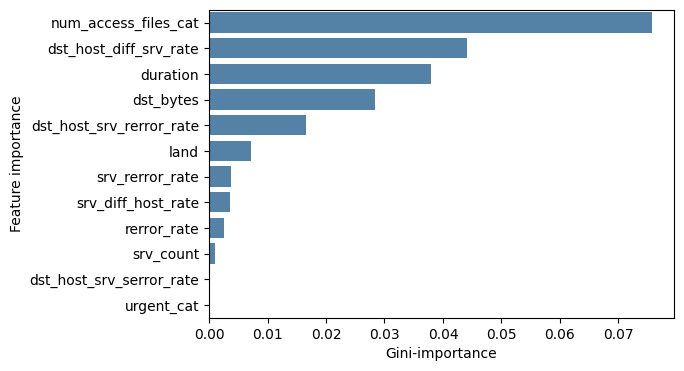

In [37]:
plot_feature_importances(best_forest_model, X_train, 12)